# Method 5 - Best Minus Rest Top 3

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 3].copy()                                                                    
short_ideas = valid_data[valid_data['pos_rank'] > 3].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

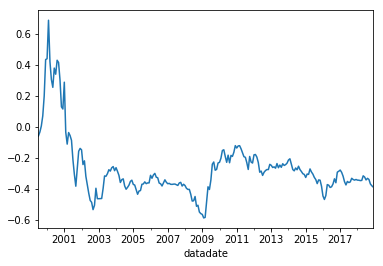

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.435362
2000-12-31   -0.222189
2001-12-31   -0.227428
2002-12-31   -0.375969
2003-12-31    0.335560
2004-12-31   -0.085176
2005-12-31   -0.026685
2006-12-31    0.006608
2007-12-31   -0.020202
2008-12-31   -0.300088
2009-12-31    0.739526
2010-12-31    0.145321
2011-12-31   -0.127564
2012-12-31   -0.010792
2013-12-31    0.009997
2014-12-31   -0.094650
2015-12-31   -0.109752
2016-12-31    0.156443
2017-12-31   -0.074219
2018-12-31   -0.074351
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     126.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.07e-56
Time:                        05:42:06   Log-Likelihood:                 453.94
No. Observations:                 234   AIC:                            -897.9
Df Residuals:                     229   BIC:                            -880.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.724      0.470      -0.003       0.006
mktrf          0.4110      0.066      6.269      0.000       0.282       0.540
me             0.2607      0.076      3.419      0.001       0.110       0.411
ia            -0.3753      0.116     -3.238      0.001      -0.604      -0.147
roe           -1.0532      0.099    -10.615      0.000      -1.249      -0.858
==============================================================================
Omnibus:                       53.630   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.668
Skew:                           0.924   Prob(JB):                     2.63e-39
Kurtosis:                       6.848   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     87.56
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.02e-45
Time:                        05:42:06   Log-Likelihood:                 453.94
No. Observations:                 234   AIC:                            -897.9
Df Residuals:                     229   BIC:                            -880.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.679      0.497      -0.003       0.007
mktrf          0.4110      0.106      3.866      0.000       0.203       0.619
me             0.2607      0.100      2.611      0.009       0.065       0.456
ia            -0.3753      0.185     -2.031      0.042      -0.737      -0.013
roe           -1.0532      0.157     -6.690      0.000      -1.362      -0.745
==============================================================================
Omnibus:                       53.630   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.668
Skew:                           0.924   Prob(JB):                     2.63e-39
Kurtosis:                       6.848   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     153.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.08e-63
Time:                        05:42:06   Log-Likelihood:                 453.94
No. Observations:                 234   AIC:                            -897.9
Df Residuals:                     229   BIC:                            -880.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.626      0.531      -0.004       0.007
mktrf          0.4110      0.109      3.783      0.000       0.198       0.624
me             0.2607      0.111      2.354      0.019       0.044       0.478
ia            -0.3753      0.179     -2.096      0.036      -0.726      -0.024
roe           -1.0532      0.171     -6.145      0.000      -1.389      -0.717
==============================================================================
Omnibus:                       53.630   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.668
Skew:                           0.924   Prob(JB):                     2.63e-39
Kurtosis:                       6.848   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     94.38
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.53e-53
Time:                        05:42:06   Log-Likelihood:                 449.01
No. Observations:                 234   AIC:                            -886.0
Df Residuals:                     228   BIC:                            -865.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.776      0.438      -0.003       0.007
mktrf          0.4727      0.067      7.030      0.000       0.340       0.605
smb            0.2203      0.089      2.483      0.014       0.046       0.395
hml            0.0981      0.105      0.938      0.349      -0.108       0.304
rmw           -1.1057      0.118     -9.349      0.000      -1.339      -0.873
cma           -0.2307      0.150     -1.535      0.126      -0.527       0.066
==============================================================================
Omnibus:                       91.777   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.512
Skew:                           1.611   Prob(JB):                     1.14e-74
Kurtosis:                       7.955   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     41.43
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.11e-30
Time:                        05:42:07   Log-Likelihood:                 449.01
No. Observations:                 234   AIC:                            -886.0
Df Residuals:                     228   BIC:                            -865.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.715      0.475      -0.003       0.007
mktrf          0.4727      0.071      6.616      0.000       0.333       0.613
smb            0.2203      0.084      2.608      0.009       0.055       0.386
hml            0.0981      0.153      0.639      0.523      -0.203       0.399
rmw           -1.1057      0.154     -7.160      0.000      -1.408      -0.803
cma           -0.2307      0.220     -1.048      0.295      -0.662       0.201
==============================================================================
Omnibus:                       91.777   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.512
Skew:                           1.611   Prob(JB):                     1.14e-74
Kurtosis:                       7.955   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     47.90
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.71e-34
Time:                        05:42:07   Log-Likelihood:                 449.01
No. Observations:                 234   AIC:                            -886.0
Df Residuals:                     228   BIC:                            -865.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.631      0.528      -0.004       0.008
mktrf          0.4727      0.070      6.752      0.000       0.335       0.610
smb            0.2203      0.089      2.470      0.013       0.046       0.395
hml            0.0981      0.117      0.836      0.403      -0.132       0.328
rmw           -1.1057      0.153     -7.209      0.000      -1.406      -0.805
cma           -0.2307      0.192     -1.204      0.229      -0.606       0.145
==============================================================================
Omnibus:                       91.777   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.512
Skew:                           1.611   Prob(JB):                     1.14e-74
Kurtosis:                       7.955   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     102.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.81e-50
Time:                        05:42:07   Log-Likelihood:                 437.87
No. Observations:                 234   AIC:                            -865.7
Df Residuals:                     229   BIC:                            -848.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.003     -0.859      0.391      -0.007       0.003
mktrf          0.5926      0.065      9.165      0.000       0.465       0.720
smb            0.7307      0.081      9.054      0.000       0.572       0.890
hml           -0.3465      0.080     -4.322      0.000      -0.505      -0.189
umd           -0.3911      0.053     -7.434      0.000      -0.495      -0.287
==============================================================================
Omnibus:                       51.930   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.740
Skew:                           1.005   Prob(JB):                     1.83e-28
Kurtosis:                       6.011   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     55.73
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.02e-33
Time:                        05:42:07   Log-Likelihood:                 437.87
No. Observations:                 234   AIC:                            -865.7
Df Residuals:                     229   BIC:                            -848.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -0.956      0.339      -0.007       0.002
mktrf          0.5926      0.091      6.524      0.000       0.415       0.771
smb            0.7307      0.093      7.898      0.000       0.549       0.912
hml           -0.3465      0.129     -2.677      0.007      -0.600      -0.093
umd           -0.3911      0.089     -4.375      0.000      -0.566      -0.216
==============================================================================
Omnibus:                       51.930   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.740
Skew:                           1.005   Prob(JB):                     1.83e-28
Kurtosis:                       6.011   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     71.95
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.18e-39
Time:                        05:42:07   Log-Likelihood:                 437.87
No. Observations:                 234   AIC:                            -865.7
Df Residuals:                     229   BIC:                            -848.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -0.954      0.340      -0.007       0.002
mktrf          0.5926      0.093      6.382      0.000       0.411       0.775
smb            0.7307      0.083      8.783      0.000       0.568       0.894
hml           -0.3465      0.135     -2.566      0.010      -0.611      -0.082
umd           -0.3911      0.093     -4.204      0.000      -0.573      -0.209
==============================================================================
Omnibus:                       51.930   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.740
Skew:                           1.005   Prob(JB):                     1.83e-28
Kurtosis:                       6.011   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     69.20
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.02e-29
Time:                        05:42:07   Log-Likelihood:                 211.28
No. Observations:                 120   AIC:                            -412.6
Df Residuals:                     115   BIC:                            -398.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.004      1.332      0.186      -0.003       0.013
mktrf          0.3841      0.110      3.506      0.001       0.167       0.601
me             0.1914      0.108      1.770      0.079      -0.023       0.406
ia            -0.5775      0.169     -3.409      0.001      -0.913      -0.242
roe           -1.0427      0.150     -6.954      0.000      -1.340      -0.746
==============================================================================
Omnibus:                       16.351   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.876
Skew:                           0.661   Prob(JB):                     3.97e-06
Kurtosis:                       4.796   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     52.30
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.02e-25
Time:                        05:42:07   Log-Likelihood:                 211.28
No. Observations:                 120   AIC:                            -412.6
Df Residuals:                     115   BIC:                            -398.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.004      1.339      0.181      -0.003       0.013
mktrf          0.3841      0.166      2.307      0.021       0.058       0.710
me             0.1914      0.129      1.487      0.137      -0.061       0.444
ia            -0.5775      0.237     -2.437      0.015      -1.042      -0.113
roe           -1.0427      0.229     -4.563      0.000      -1.491      -0.595
==============================================================================
Omnibus:                       16.351   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.876
Skew:                           0.661   Prob(JB):                     3.97e-06
Kurtosis:                       4.796   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     100.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.38e-36
Time:                        05:42:07   Log-Likelihood:                 211.28
No. Observations:                 120   AIC:                            -412.6
Df Residuals:                     115   BIC:                            -398.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.004      1.290      0.197      -0.003       0.014
mktrf          0.3841      0.171      2.246      0.025       0.049       0.719
me             0.1914      0.143      1.335      0.182      -0.090       0.473
ia            -0.5775      0.212     -2.727      0.006      -0.993      -0.162
roe           -1.0427      0.255     -4.095      0.000      -1.542      -0.544
==============================================================================
Omnibus:                       16.351   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.876
Skew:                           0.661   Prob(JB):                     3.97e-06
Kurtosis:                       4.796   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     54.40
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.29e-28
Time:                        05:42:07   Log-Likelihood:                 210.91
No. Observations:                 120   AIC:                            -409.8
Df Residuals:                     114   BIC:                            -393.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.004      1.615      0.109      -0.002       0.015
mktrf          0.5411      0.116      4.650      0.000       0.311       0.772
smb            0.1603      0.132      1.217      0.226      -0.101       0.421
hml           -0.1502      0.162     -0.930      0.354      -0.470       0.170
rmw           -0.9442      0.190     -4.958      0.000      -1.321      -0.567
cma           -0.2198      0.209     -1.053      0.294      -0.633       0.194
==============================================================================
Omnibus:                       48.871   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.702
Skew:                           1.613   Prob(JB):                     6.17e-27
Kurtosis:                       6.706   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     30.41
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.54e-19
Time:                        05:42:07   Log-Likelihood:                 210.91
No. Observations:                 120   AIC:                            -409.8
Df Residuals:                     114   BIC:                            -393.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.004      1.830      0.067      -0.000       0.014
mktrf          0.5411      0.130      4.158      0.000       0.286       0.796
smb            0.1603      0.116      1.378      0.168      -0.068       0.388
hml           -0.1502      0.107     -1.400      0.162      -0.360       0.060
rmw           -0.9442      0.211     -4.480      0.000      -1.357      -0.531
cma           -0.2198      0.248     -0.887      0.375      -0.705       0.266
==============================================================================
Omnibus:                       48.871   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.702
Skew:                           1.613   Prob(JB):                     6.17e-27
Kurtosis:                       6.706   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     33.48
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.66e-21
Time:                        05:42:07   Log-Likelihood:                 210.91
No. Observations:                 120   AIC:                            -409.8
Df Residuals:                     114   BIC:                            -393.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.004      1.629      0.103      -0.001       0.015
mktrf          0.5411      0.112      4.827      0.000       0.321       0.761
smb            0.1603      0.117      1.375      0.169      -0.068       0.389
hml           -0.1502      0.070     -2.137      0.033      -0.288      -0.012
rmw           -0.9442      0.214     -4.413      0.000      -1.364      -0.525
cma           -0.2198      0.205     -1.074      0.283      -0.621       0.181
==============================================================================
Omnibus:                       48.871   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.702
Skew:                           1.613   Prob(JB):                     6.17e-27
Kurtosis:                       6.706   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     71.19
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.24e-30
Time:                        05:42:07   Log-Likelihood:                 212.48
No. Observations:                 120   AIC:                            -415.0
Df Residuals:                     115   BIC:                            -401.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.004      0.483      0.630      -0.006       0.010
mktrf          0.6612      0.096      6.921      0.000       0.472       0.850
smb            0.6429      0.109      5.910      0.000       0.427       0.858
hml           -0.5918      0.109     -5.432      0.000      -0.808      -0.376
umd           -0.3575      0.067     -5.322      0.000      -0.491      -0.224
==============================================================================
Omnibus:                       19.163   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.480
Skew:                           0.784   Prob(JB):                     6.54e-07
Kurtosis:                       4.799   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     48.22
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.45e-24
Time:                        05:42:07   Log-Likelihood:                 212.48
No. Observations:                 120   AIC:                            -415.0
Df Residuals:                     115   BIC:                            -401.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.560      0.576      -0.005       0.009
mktrf          0.6612      0.126      5.230      0.000       0.413       0.909
smb            0.6429      0.098      6.538      0.000       0.450       0.836
hml           -0.5918      0.120     -4.920      0.000      -0.828      -0.356
umd           -0.3575      0.091     -3.945      0.000      -0.535      -0.180
==============================================================================
Omnibus:                       19.163   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.480
Skew:                           0.784   Prob(JB):                     6.54e-07
Kurtosis:                       4.799   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     76.08
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.11e-31
Time:                        05:42:07   Log-Likelihood:                 212.48
No. Observations:                 120   AIC:                            -415.0
Df Residuals:                     115   BIC:                            -401.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.562      0.574      -0.005       0.009
mktrf          0.6612      0.126      5.264      0.000       0.415       0.907
smb            0.6429      0.085      7.572      0.000       0.476       0.809
hml           -0.5918      0.093     -6.378      0.000      -0.774      -0.410
umd           -0.3575      0.096     -3.737      0.000      -0.545      -0.170
==============================================================================
Omnibus:                       19.163   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.480
Skew:                           0.784   Prob(JB):                     6.54e-07
Kurtosis:                       4.799   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     57.78
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.42e-26
Time:                        05:42:07   Log-Likelihood:                 265.33
No. Observations:                 114   AIC:                            -520.7
Df Residuals:                     109   BIC:                            -507.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.572      0.568      -0.006       0.003
mktrf          0.4064      0.071      5.727      0.000       0.266       0.547
me             0.4102      0.110      3.744      0.000       0.193       0.627
ia             0.0730      0.152      0.480      0.632      -0.228       0.374
roe           -1.0098      0.134     -7.562      0.000      -1.274      -0.745
==============================================================================
Omnibus:                       34.223   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.765
Skew:                           1.114   Prob(JB):                     1.44e-19
Kurtosis:                       6.647   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     48.76
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.88e-23
Time:                        05:42:07   Log-Likelihood:                 265.33
No. Observations:                 114   AIC:                            -520.7
Df Residuals:                     109   BIC:                            -507.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.633      0.527      -0.006       0.003
mktrf          0.4064      0.088      4.618      0.000       0.234       0.579
me             0.4102      0.141      2.900      0.004       0.133       0.687
ia             0.0730      0.193      0.379      0.705      -0.305       0.451
roe           -1.0098      0.180     -5.622      0.000      -1.362      -0.658
==============================================================================
Omnibus:                       34.223   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.765
Skew:                           1.114   Prob(JB):                     1.44e-19
Kurtosis:                       6.647   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     59.69
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.33e-26
Time:                        05:42:07   Log-Likelihood:                 265.33
No. Observations:                 114   AIC:                            -520.7
Df Residuals:                     109   BIC:                            -507.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.612      0.541      -0.006       0.003
mktrf          0.4064      0.088      4.628      0.000       0.234       0.578
me             0.4102      0.163      2.513      0.012       0.090       0.730
ia             0.0730      0.215      0.340      0.734      -0.348       0.494
roe           -1.0098      0.181     -5.587      0.000      -1.364      -0.656
==============================================================================
Omnibus:                       34.223   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.765
Skew:                           1.114   Prob(JB):                     1.44e-19
Kurtosis:                       6.647   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     47.33
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.09e-25
Time:                        05:42:07   Log-Likelihood:                 266.61
No. Observations:                 114   AIC:                            -521.2
Df Residuals:                     108   BIC:                            -504.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -0.897      0.372      -0.007       0.003
mktrf          0.4282      0.067      6.369      0.000       0.295       0.561
smb            0.3473      0.109      3.182      0.002       0.131       0.564
hml            0.5074      0.139      3.645      0.000       0.232       0.783
rmw           -0.9845      0.170     -5.776      0.000      -1.322      -0.647
cma           -0.2049      0.216     -0.947      0.346      -0.634       0.224
==============================================================================
Omnibus:                       12.677   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.754
Skew:                           0.661   Prob(JB):                     0.000625
Kurtosis:                       4.165   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     31.62
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.02e-19
Time:                        05:42:07   Log-Likelihood:                 266.61
No. Observations:                 114   AIC:                            -521.2
Df Residuals:                     108   BIC:                            -504.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.003     -0.811      0.417      -0.007       0.003
mktrf          0.4282      0.066      6.445      0.000       0.298       0.558
smb            0.3473      0.125      2.773      0.006       0.102       0.593
hml            0.5074      0.174      2.922      0.003       0.167       0.848
rmw           -0.9845      0.205     -4.795      0.000      -1.387      -0.582
cma           -0.2049      0.231     -0.889      0.374      -0.657       0.247
==============================================================================
Omnibus:                       12.677   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.754
Skew:                           0.661   Prob(JB):                     0.000625
Kurtosis:                       4.165   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     43.68
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.98e-24
Time:                        05:42:07   Log-Likelihood:                 266.61
No. Observations:                 114   AIC:                            -521.2
Df Residuals:                     108   BIC:                            -504.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.003     -0.807      0.420      -0.007       0.003
mktrf          0.4282      0.068      6.318      0.000       0.295       0.561
smb            0.3473      0.134      2.584      0.010       0.084       0.611
hml            0.5074      0.144      3.526      0.000       0.225       0.790
rmw           -0.9845      0.184     -5.350      0.000      -1.345      -0.624
cma           -0.2049      0.235     -0.874      0.382      -0.665       0.255
==============================================================================
Omnibus:                       12.677   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.754
Skew:                           0.661   Prob(JB):                     0.000625
Kurtosis:                       4.165   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     44.29
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.95e-22
Time:                        05:42:07   Log-Likelihood:                 255.49
No. Observations:                 114   AIC:                            -501.0
Df Residuals:                     109   BIC:                            -487.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.003     -1.253      0.213      -0.008       0.002
mktrf          0.4663      0.073      6.360      0.000       0.321       0.612
smb            0.5839      0.114      5.108      0.000       0.357       0.811
hml            0.4184      0.118      3.554      0.001       0.185       0.652
umd           -0.2954      0.089     -3.326      0.001      -0.471      -0.119
==============================================================================
Omnibus:                       16.467   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.840
Skew:                           0.671   Prob(JB):                     2.45e-06
Kurtosis:                       4.907   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     37.61
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.69e-20
Time:                        05:42:07   Log-Likelihood:                 255.49
No. Observations:                 114   AIC:                            -501.0
Df Residuals:                     109   BIC:                            -487.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.002     -1.501      0.133      -0.008       0.001
mktrf          0.4663      0.074      6.262      0.000       0.320       0.612
smb            0.5839      0.124      4.712      0.000       0.341       0.827
hml            0.4184      0.162      2.589      0.010       0.102       0.735
umd           -0.2954      0.098     -3.001      0.003      -0.488      -0.102
==============================================================================
Omnibus:                       16.467   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.840
Skew:                           0.671   Prob(JB):                     2.45e-06
Kurtosis:                       4.907   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     45.81
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.59e-22
Time:                        05:42:07   Log-Likelihood:                 255.49
No. Observations:                 114   AIC:                            -501.0
Df Residuals:                     109   BIC:                            -487.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.002     -1.587      0.112      -0.007       0.001
mktrf          0.4663      0.074      6.259      0.000       0.320       0.612
smb            0.5839      0.112      5.226      0.000       0.365       0.803
hml            0.4184      0.162      2.578      0.010       0.100       0.736
umd           -0.2954      0.100     -2.955      0.003      -0.491      -0.099
==============================================================================
Omnibus:                       16.467   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.840
Skew:                           0.671   Prob(JB):                     2.45e-06
Kurtosis:                       4.907   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""